In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import my_statistics as ms
import seaborn as sns
import sklearn.tree
from tqdm.notebook import tqdm
import copy
import decision_trees_class as dtc
import random

In [2]:
hitters = pd.read_csv('Gradivo/Hitters.csv')

In [3]:
hitters.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N


In [4]:
hitters.dropna(axis=0, subset=['Salary'], inplace=True)

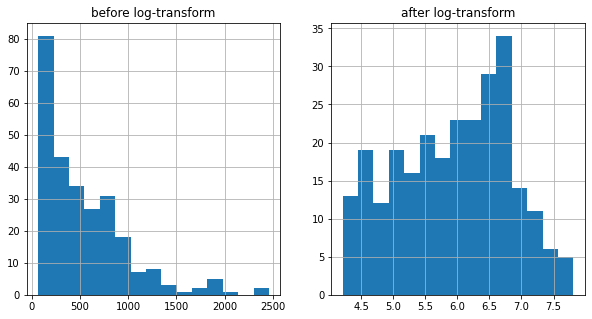

In [5]:
# salary log transform
salary_log = np.log(hitters.Salary)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(x = hitters.Salary, bins=15)
ax[0].set_title('before log-transform')
ax[0].grid()
ax[1].hist(x = salary_log, bins=15)
ax[1].set_title('after log-transform')
ax[1].grid()

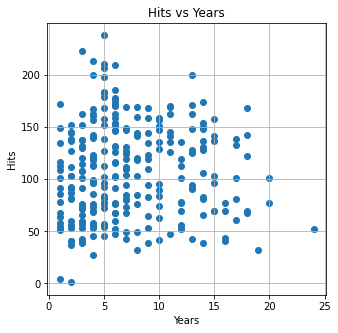

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(hitters.Years, hitters.Hits)
plt.title('Hits vs Years')
plt.xlabel('Years')
plt.ylabel('Hits')
plt.grid()

###  Recursive binary splitting

In [7]:
hitters_num = hitters.loc[:,hitters.dtypes == 'int64']

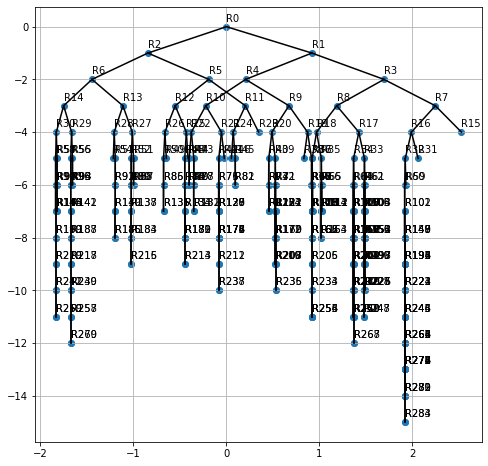

In [8]:
features = ['Hits', 'Runs', 'Walks', 'Years', 'RBI']
r_size=3
tree = dtc.DecisionTree(training_inputs = hitters_num[features],
                        training_outputs = salary_log,
                        s_div=30,
                        max_leaf_size=r_size,
                        criterion = 'RSS')
tree.plot_tree()

In [9]:
pred, cl_pred = tree.predict(hitters_num[features])

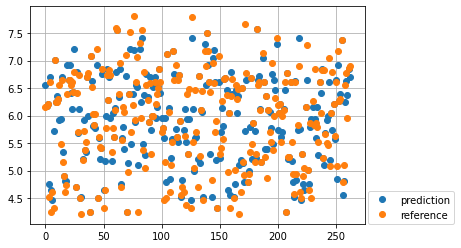

In [10]:
plt.plot(np.arange(len(pred)), pred,'o', label='prediction')
plt.plot(np.arange(len(pred)), salary_log,'o', label='reference')
plt.legend(loc=(1.01,0))
plt.grid()

In [11]:
# predictions for different R size limits
features = ['Hits', 'Runs', 'Walks', 'Years', 'RBI']
errors, predictions, refs = {}, {}, {}
r_list = [50, 30, 10, 5, 3]
for r_size in tqdm(r_list):
    my_tree_r = dtc.DecisionTree(hitters_num[features], salary_log, s_div=100,
                             max_leaf_size=r_size, criterion='RSS')
    y_pred_r, y_cl_r = my_tree_r.predict(hitters_num[features])
    dif = abs(salary_log - y_pred_r)
    errors[r_size], predictions[r_size] = dif, y_pred_r

  0%|          | 0/5 [00:00<?, ?it/s]

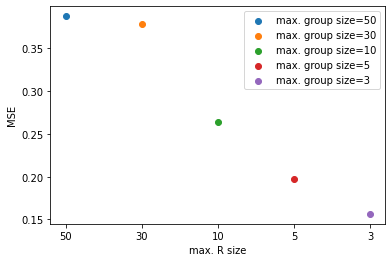

In [12]:
# MSE for different R size limits
for i,j in enumerate(r_list):
    plt.scatter(i, ms.MSE(predictions[j], salary_log),
                label=f'max. group size={j}')
plt.xticks(np.arange(len(r_list)), r_list)
plt.legend()
plt.xlabel('max. R size')
plt.ylabel('MSE');

(0.0, 100.0)

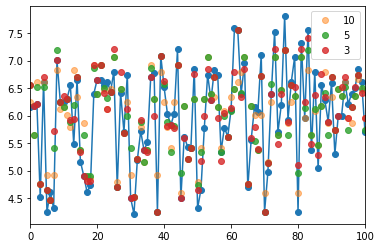

In [13]:
# predictions for different R sizes
plt.plot(np.arange(len(salary_log)), salary_log,'-o')
#plt.plot(np.arange(len(predictions[50])), predictions[50],'o', label=50)
#plt.plot(np.arange(len(predictions[30])), predictions[30], 'o', label=30,alpha=.5)
plt.plot(np.arange(len(predictions[10])), predictions[10], 'o', label=10, alpha=.5)
plt.plot(np.arange(len(predictions[5])), predictions[5], 'o', label=5, alpha=.8)
plt.plot(np.arange(len(predictions[3])), predictions[3], 'o', label=3, alpha=.8)
plt.legend()
plt.xlim(0,100)

### Determining $\alpha$ values and treesizes for tree pruning purpuses

In [14]:
tree_scores_alpha, tree_sizes_l = [], []
alpha_array = np.linspace(0,0.5,10)
for alpha in tqdm(alpha_array):
    tree_scores, tree_sizes = tree.tree_pruning(alpha=alpha, all_=True)
    tree_scores_alpha.append(tree_scores)
    tree_sizes_l.append(tree_sizes)

  0%|          | 0/10 [00:00<?, ?it/s]

α_0; tree score min = 41.471110302678454, tree size = 143
α_1; tree score min = 49.4155547471229, tree size = 143
α_2; tree score min = 57.35999919156734, tree size = 143
α_3; tree score min = 65.26797604491601, tree size = 142
α_4; tree score min = 73.12860534892049, tree size = 141
α_5; tree score min = 80.68977539176439, tree size = 135
α_6; tree score min = 88.18977539176439, tree size = 135
α_7; tree score min = 91.57556075362325, tree size = 25
α_8; tree score min = 92.85252411010605, tree size = 16
α_9; tree score min = 93.74141299899493, tree size = 16


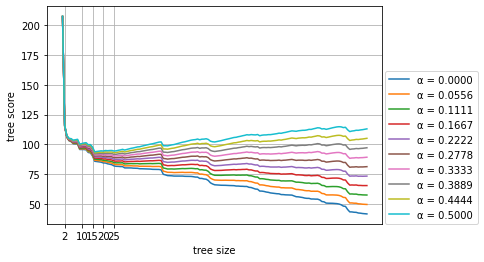

In [15]:
for i,j in enumerate(alpha_array):
    plt.plot(tree_sizes_l[i], tree_scores_alpha[i], label=f'α = {j:.4f}')
    min_ind = np.argmin(tree_scores_alpha[i])
    print(f'α_{i}; tree score min = {tree_scores_alpha[i][min_ind]}, tree size = {tree_sizes_l[i][min_ind]}')
plt.legend(loc = (1.01, 0))
plt.ylabel('tree score')
plt.xlabel('tree size')
plt.xticks(ticks=[2,10,15,20,25])
plt.grid()

In [16]:
# find alphas and corresponding tree sizes
alphas, sizes = tree.find_alphas(alpha_range=np.linspace(0,0.5,10))

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
# k-fold CV
features = ['Hits', 'Runs', 'Walks', 'Years', 'RBI']
r_size=3
errors =  dtc.k_fold_CV_for_decision_tree_pruning(hitters_num[features], 
                                                 salary_log, k=5,
                                                 alpha=alphas,
                                                 sizes=sizes, r_size=r_size,
                                                 criterion='RSS')

Main loop:   0%|          | 0/6 [00:00<?, ?it/s]

loop for α = 0.0000:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.1667:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.2222:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.2778:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.3889:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.4444:   0%|          | 0/5 [00:00<?, ?it/s]

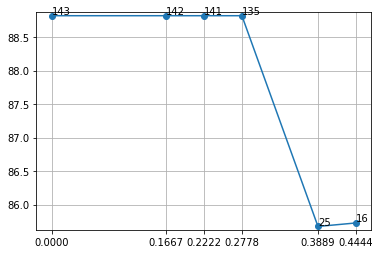

In [18]:
plt.plot(alphas, errors, '-o')
for i in range(len(alphas)):
    plt.annotate(sizes[i], (alphas[i], errors[i]+0.02))
plt.grid()
plt.ylim(min(errors)-0.05, max(errors)+0.05)
plt.xticks(alphas);

In [19]:
tree = dtc.DecisionTree(hitters_num[features], salary_log, s_div=100,
                        max_leaf_size=r_size, criterion='RSS')
tree.shrink_tree(size_goal=sizes[4])
y_pred, cl_pred = tree.predict(hitters_num[features])

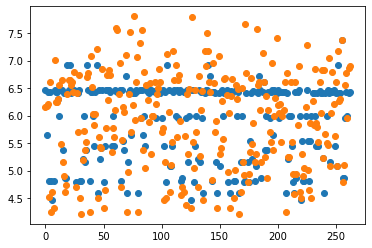

In [20]:
plt.plot(np.arange(len(y_pred)), y_pred,'o')
plt.plot(np.arange(len(y_pred)), salary_log,'o')
#plt.xlim(0,50)

##### Decision trees using sklearn

In [21]:
reg_tree = sklearn.tree.DecisionTreeRegressor()
reg_tree_fit = reg_tree.fit(hitters_num, hitters.Salary)

In [22]:
sklearn_pred = reg_tree_fit.predict(hitters_num)

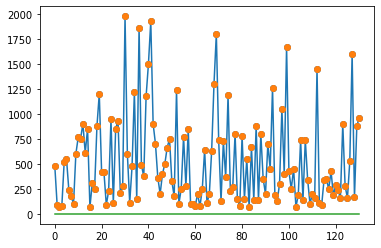

In [23]:
plt.plot(np.arange(131), reg_tree_fit.predict(hitters_num[1::2]),'-o')
plt.plot(np.arange(131),hitters.Salary[1::2],'o')
plt.plot(np.arange(131), reg_tree_fit.predict(hitters_num[1::2])- hitters.Salary[1::2])

### Classification Trees

In [24]:
h_df = pd.read_csv('Gradivo/Heart.csv')
h_df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [25]:
h_df.head(2)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes


In [26]:
HD_dummy = np.zeros(h_df.shape[0])
HD_dummy[h_df.AHD == 'Yes'], HD_dummy[h_df.AHD == 'No'] = 1, 0

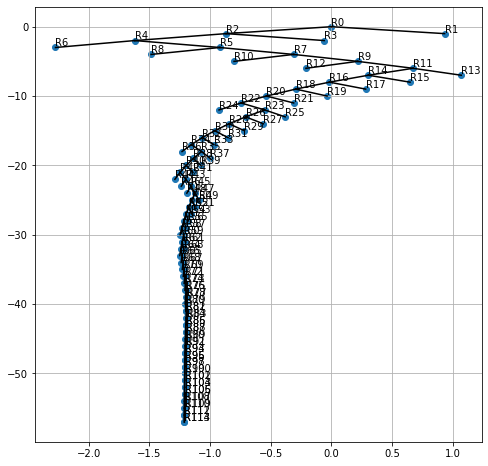

In [27]:
features = ['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
            'ExAng', 'Oldpeak', 'Slope', 'Ca']
class_tree = dtc.DecisionTree(h_df[features][::2], HD_dummy[::2], s_div=30,
                              max_leaf_size=30, criterion='Gini')
class_tree.plot_tree()

In [28]:
# cunfusion matrix for seen data
y_cl_pred, y_cl = class_tree.predict(h_df[features][::2])
ms.confusion_matrix(y_cl_pred, HD_dummy[::2], print_=True);

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 75       |         FN = 8        |  83  |
|     Yes     |         FP = 5        |         TP = 64       |  69  |
|             | specificity = 93.75 % | sensitivity = 88.89 % |      |
|     Sums    |           83          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+


In [29]:
print(f'Error rate: {ms.classification_error_rate(y_cl_pred, HD_dummy[::2]):.3f}')

Error rate: 0.086


In [30]:
y_cl_pred, y_cl = class_tree.predict(h_df[features][1::2])
ms.confusion_matrix(y_cl_pred, HD_dummy[1::2], print_=True);

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 54       |         FN = 24       |  78  |
|     Yes     |         FP = 30       |         TP = 43       |  73  |
|             | specificity = 64.29 % | sensitivity = 64.18 % |      |
|     Sums    |           78          |           67          | 151  |
+-------------+-----------------------+-----------------------+------+


In [31]:
print(f'Error rate: {ms.classification_error_rate(y_cl_pred, HD_dummy[1::2]):.3f}')

Error rate: 0.358


In [32]:
tree_scores_alpha, tree_sizes_l = [], []
alpha_array = np.linspace(0,1.5,20)
for alpha in tqdm(alpha_array):
    tree_scores, tree_sizes = class_tree.tree_pruning(alpha=alpha, all_=True)
    tree_scores_alpha.append(tree_scores)
    tree_sizes_l.append(tree_sizes)

  0%|          | 0/20 [00:00<?, ?it/s]

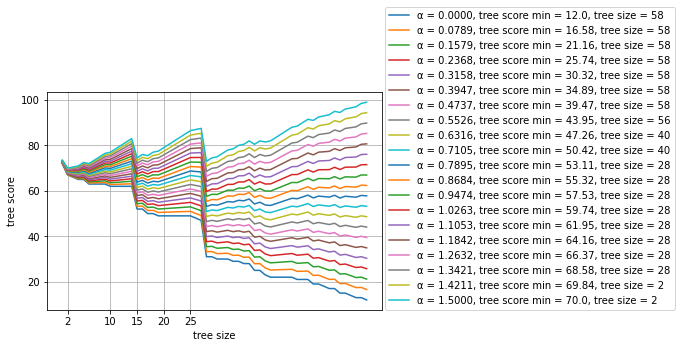

In [33]:
for i,j in enumerate(alpha_array):
    min_ind = np.argmin(tree_scores_alpha[i])
    plt.plot(tree_sizes_l[i], tree_scores_alpha[i],
             label=f'α = {j:.4f}, tree score min = {tree_scores_alpha[i][min_ind]:.4}, tree size = {tree_sizes_l[i][min_ind]}')
    
plt.legend(loc = (1.01, 0))
plt.ylabel('tree score')
plt.xlabel('tree size')
plt.xticks(ticks=[2,10,15,20,25])
plt.grid()

In [34]:
# find alphas and corresponding tree sizes
alphas, sizes = class_tree.find_alphas(alpha_array)

  0%|          | 0/20 [00:00<?, ?it/s]

In [35]:
alphas, sizes

([0.0,
  0.5526315789473684,
  0.631578947368421,
  0.7894736842105263,
  1.4210526315789473],
 [58, 56, 40, 28, 2])

In [36]:
# k-fold CV
features = ['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
            'ExAng', 'Oldpeak', 'Slope', 'Ca']
r_size=3
errors =  dtc.k_fold_CV_for_decision_tree_pruning(h_df[features], 
                                                 HD_dummy, k=5,
                                                 alpha=alphas,
                                                 sizes=sizes, r_size=r_size,
                                                 criterion='gini')

Main loop:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.0000:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.5526:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.6316:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.7895:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 1.4211:   0%|          | 0/5 [00:00<?, ?it/s]

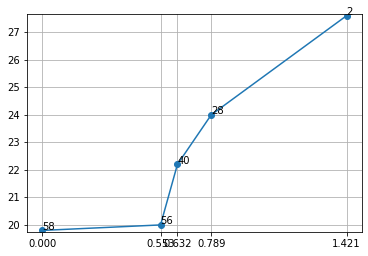

In [37]:
plt.plot(alphas, errors, '-o')
for i in range(len(alphas)):
    plt.annotate(sizes[i], (alphas[i], errors[i]+0.02));
plt.grid()
plt.ylim(min(errors)-0.05, max(errors)+0.05)
plt.xticks(alphas);

In [38]:
class_tree.to_original()
class_tree.shrink_tree(size_goal=40)

In [39]:
# confusion matrix for unseen data
y_cl_pred, y_cl = class_tree.predict(h_df[features][1::2])
ms.confusion_matrix(y_cl_pred, HD_dummy[1::2], print_=True);

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 61       |         FN = 24       |  85  |
|     Yes     |         FP = 23       |         TP = 43       |  66  |
|             | specificity = 72.62 % | sensitivity = 64.18 % |      |
|     Sums    |           85          |           67          | 151  |
+-------------+-----------------------+-----------------------+------+


In [40]:
print(f'Error rate: {ms.classification_error_rate(y_cl_pred, HD_dummy[1::2]):.3f}')

Error rate: 0.311


### Bagging

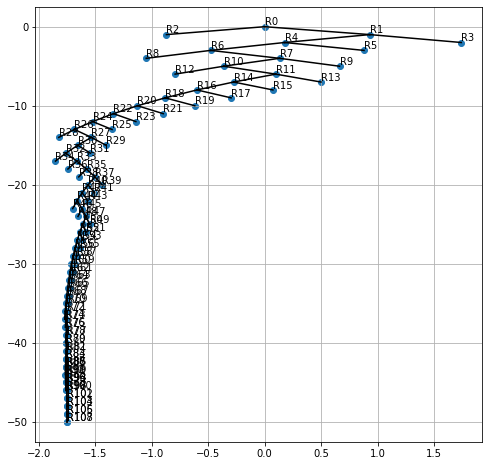

In [41]:
features = ['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
            'ExAng', 'Oldpeak', 'Slope', 'Ca']
class_tree = dtc.DecisionTree(h_df[features], HD_dummy, s_div=30,
                              max_leaf_size=30, criterion='Gini')
class_tree.plot_tree()

In [42]:
class_tree.bagging(B=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
y_pred_bagging = class_tree.bagging_predict(h_df[features][1::2])
ms.confusion_matrix(y_pred_bagging, HD_dummy[1::2], print_=True);

  0%|          | 0/100 [00:00<?, ?it/s]

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 65       |         FN = 11       |  76  |
|     Yes     |         FP = 19       |         TP = 56       |  75  |
|             | specificity = 77.38 % | sensitivity = 83.58 % |      |
|     Sums    |           76          |           67          | 151  |
+-------------+-----------------------+-----------------------+------+


In [44]:
print(f'Error rate: {ms.classification_error_rate(y_pred_bagging, HD_dummy[1::2]):.3f}')

Error rate: 0.199


In [45]:
# from shrinked to original tree
class_tree.to_original()

In [46]:
class_tree.bagging(B=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
y_pred_bagging = class_tree.bagging_predict(h_df[features][1::2])
ms.confusion_matrix(y_pred_bagging, HD_dummy[1::2], print_=True);

  0%|          | 0/1000 [00:00<?, ?it/s]

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 70       |         FN = 12       |  82  |
|     Yes     |         FP = 14       |         TP = 55       |  69  |
|             | specificity = 83.33 % | sensitivity = 82.09 % |      |
|     Sums    |           82          |           67          | 151  |
+-------------+-----------------------+-----------------------+------+


In [48]:
print(f'Error rate: {ms.classification_error_rate(y_pred_bagging, HD_dummy[1::2]):.3f}')

Error rate: 0.172


### Random forests

In [49]:
my_tree = dtc.DecisionTree(h_df[features][1::2], HD_dummy[1::2], s_div=20, max_leaf_size=10, criterion='Gini')

In [52]:
my_tree.random_forest(B=500)

  0%|          | 0/500 [00:00<?, ?it/s]

In [53]:
y_pred_rf = my_tree.random_forest_predict(h_df[features][::2])
ms.confusion_matrix(y_pred_rf, HD_dummy[::2], print_=True)
print(f'Error rate: {ms.classification_error_rate(y_pred_rf, HD_dummy[::2]):.3f}')

  0%|          | 0/500 [00:00<?, ?it/s]

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 68       |         FN = 33       | 101  |
|     Yes     |         FP = 12       |         TP = 39       |  51  |
|             | specificity = 85.00 % | sensitivity = 54.17 % |      |
|     Sums    |          101          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.296


In [56]:
predictions = []
error_rates = []
for b in range(100,1500,100):
    my_tree.random_forest(B=b)
    y_pred_rf = my_tree.random_forest_predict(h_df[features][::2])
    predictions.append(y_pred_rf)
    print(f'B = {b}:\n')
    ms.confusion_matrix(y_pred_rf, HD_dummy[::2], print_=True)
    print(f'Error rate: {ms.classification_error_rate(y_pred_rf, HD_dummy[::2]):.3f}')
    error_rates.append(ms.classification_error_rate(y_pred_rf, HD_dummy[::2]))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

B = 100:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 54       |         FN = 25       |  79  |
|     Yes     |         FP = 26       |         TP = 47       |  73  |
|             | specificity = 67.50 % | sensitivity = 65.28 % |      |
|     Sums    |           79          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.336


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

B = 200:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 52       |         FN = 28       |  80  |
|     Yes     |         FP = 28       |         TP = 44       |  72  |
|             | specificity = 65.00 % | sensitivity = 61.11 % |      |
|     Sums    |           80          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.368


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

B = 300:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 56       |         FN = 29       |  85  |
|     Yes     |         FP = 24       |         TP = 43       |  67  |
|             | specificity = 70.00 % | sensitivity = 59.72 % |      |
|     Sums    |           85          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.349


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

B = 400:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 62       |         FN = 47       | 109  |
|     Yes     |         FP = 18       |         TP = 25       |  43  |
|             | specificity = 77.50 % | sensitivity = 34.72 % |      |
|     Sums    |          109          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.428


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

B = 500:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 64       |         FN = 32       |  96  |
|     Yes     |         FP = 16       |         TP = 40       |  56  |
|             | specificity = 80.00 % | sensitivity = 55.56 % |      |
|     Sums    |           96          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.316


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

B = 600:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 61       |         FN = 27       |  88  |
|     Yes     |         FP = 19       |         TP = 45       |  64  |
|             | specificity = 76.25 % | sensitivity = 62.50 % |      |
|     Sums    |           88          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.303


  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

B = 700:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 55       |         FN = 43       |  98  |
|     Yes     |         FP = 25       |         TP = 29       |  54  |
|             | specificity = 68.75 % | sensitivity = 40.28 % |      |
|     Sums    |           98          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.447


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

B = 800:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 57       |         FN = 29       |  86  |
|     Yes     |         FP = 23       |         TP = 43       |  66  |
|             | specificity = 71.25 % | sensitivity = 59.72 % |      |
|     Sums    |           86          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.342


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

B = 900:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 54       |         FN = 26       |  80  |
|     Yes     |         FP = 26       |         TP = 46       |  72  |
|             | specificity = 67.50 % | sensitivity = 63.89 % |      |
|     Sums    |           80          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.342


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

B = 1000:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 57       |         FN = 34       |  91  |
|     Yes     |         FP = 23       |         TP = 38       |  61  |
|             | specificity = 71.25 % | sensitivity = 52.78 % |      |
|     Sums    |           91          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.375


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

B = 1100:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 57       |         FN = 28       |  85  |
|     Yes     |         FP = 23       |         TP = 44       |  67  |
|             | specificity = 71.25 % | sensitivity = 61.11 % |      |
|     Sums    |           85          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.336


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

B = 1200:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 58       |         FN = 39       |  97  |
|     Yes     |         FP = 22       |         TP = 33       |  55  |
|             | specificity = 72.50 % | sensitivity = 45.83 % |      |
|     Sums    |           97          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.401


  0%|          | 0/1300 [00:00<?, ?it/s]

  0%|          | 0/1300 [00:00<?, ?it/s]

B = 1300:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 49       |         FN = 23       |  72  |
|     Yes     |         FP = 31       |         TP = 49       |  80  |
|             | specificity = 61.25 % | sensitivity = 68.06 % |      |
|     Sums    |           72          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.355


  0%|          | 0/1400 [00:00<?, ?it/s]

  0%|          | 0/1400 [00:00<?, ?it/s]

B = 1400:

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 57       |         FN = 29       |  86  |
|     Yes     |         FP = 23       |         TP = 43       |  66  |
|             | specificity = 71.25 % | sensitivity = 59.72 % |      |
|     Sums    |           86          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+
Error rate: 0.342


Text(0, 0.5, 'classification error rate')

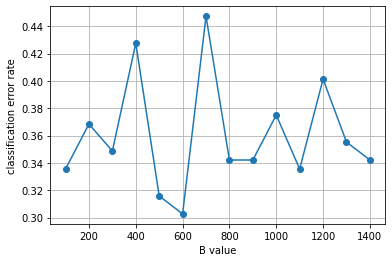

In [62]:
plt.plot(np.arange(100,1500,100),error_rates,'o-')
plt.grid()
plt.xlabel('B value')
plt.ylabel('classification error rate')